In [1]:
import pandas as pd
import cudf as gd
import time
from sklearn.model_selection import StratifiedKFold
import numpy as np
import warnings
from numba import cuda
warnings.filterwarnings("ignore")
print('cudf version',gd.__version__)

cudf version 0.6.1+0.gbeb4ef3.dirty


### I didn't expect to use rapids at all for the __[Google Landmark Recognition 2019](https://www.kaggle.com/c/landmark-recognition-2019)__ but it turned out that stratified kfold operation could be painfully slow. In this notebook, a cudf based implementation is shown to achieve 1000+ speedup.

### Table of contents
[1. Implementation of cudf based stratified kfold split](#imp)<br>
[2. Sanity Check with toy data](#san)<br>
[3. The google landmark dataset](#land)<br>
[4. Measure the runtime](#runtime)<br>

### Implementation of cudf based stratified kfold split
<a id="imp"></a>

In [2]:
class StratifiedKFold_cudf_gpu:
    """Stratified K-Folds cross-validator using cudf on gpu.
    Functionality is the same as 
    https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
    Parameters
    ----------
    n_splits : int, default=3
        Number of folds. Must be at least 2.
        .. versionchanged:: 0.20
            ``n_splits`` default value will change from 3 to 5 in v0.22.
    shuffle : boolean, optional
        Whether to shuffle each stratification of the data before splitting
        into batches.
    random_state : int, default=42, RandomState instance, which is the seed used 
        by the random number generator;
    tpb: int, default=32, number of threads per thread block. A thread block is a group of threads 
        to process the group of samples with same value of y. If the number of unique values of 
        y is small,the group size is large and tpb should increase accordingly. The largest value
        of tpb is 1024 and it should be multiples of 32.
    
    Examples
    --------
    >>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
    >>> y = np.array([0, 0, 1, 1])
    >>> skf = StratifiedKFold_cudf_gpu(n_splits=2,random_state=None, shuffle=False)
    >>> for train_index, test_index in skf.split(X, y):
    ...    print("TRAIN:", train_index, "TEST:", test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [1 3] TEST: [0 2]
    TRAIN: [0 2] TEST: [1 3]
    Notes
    -----
    Train and test sizes may be different in each fold, with a difference of at most ``n_classes``.
    """
    def __init__(self,n_splits=3,shuffle=True,random_state=42,tpb=32):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.seed = random_state
        self.tpb = tpb # threads per thread block
        
    def get_n_splits(self, X=None, y=None):
        return self.n_splits
              
    def split(self,x,y):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        y : array-like, shape (n_samples,)
            The target variable for supervised learning problems.
            Stratification is done based on the y labels.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        Notes
        -----
        Randomized CV splitters may return different results for each call of
        split. You can make the results identical by setting ``random_state``
        to an integer.
        """
        assert x.shape[0] == y.shape[0]
        df = gd.DataFrame()
        x = np.array(x)
        y = np.array(y)
        ids = np.arange(x.shape[0])
        
        if self.shuffle:
            np.random.seed(self.seed)
            np.random.shuffle(ids)
            x = x[ids]
            y = y[ids]
        
        cols = []
        if len(x.shape)==1:
            df['x'] = np.ascontiguousarray(x)
            cols.append('x')
        else:
            for c in range(x.shape[1]):
                df['x%d'%c] = np.ascontiguousarray(x[:,c])
                cols.append('x%d'%c)
        df['y'] = np.ascontiguousarray(y)
        df['ids'] = ids
    
        grpby = df.groupby(['y'], method="cudf")

        def get_order_in_group(y,ids,order):
            for i in range(cuda.threadIdx.x, len(y), cuda.blockDim.x):
                order[i] = i

        got = grpby.apply_grouped(get_order_in_group,incols=['y','ids'],
                                  outcols={'order': np.int32},
                                  tpb=self.tpb)

        got = got.sort_values('ids')
            
        dx = got.to_pandas()
        del got,df
        
        for i in range(self.n_splits):
            mask = dx['order']%self.n_splits==i
            train = dx.loc[~mask,'ids'].values
            test = dx.loc[mask,'ids'].values
            yield train,test     

### Sanity check
<a id="san"></a>

In [3]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
skf = StratifiedKFold_cudf_gpu(n_splits=2,random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [1 3] TEST: [0 2]
TRAIN: [0 2] TEST: [1 3]


### A real world example with the google landmark dataset
<a id="land"></a>

In [4]:
%%time
path = '../../landreg/input/train.csv'
cols = ['id','url','landmark_id']
dtypes = ['str','str','int32']
train = gd.read_csv(path,names=cols,dtype=dtypes,skiprows=1) # skip the header

CPU times: user 440 ms, sys: 152 ms, total: 592 ms
Wall time: 595 ms


In [5]:
df = train.head().to_pandas()
df.head()

,id,url,landmark_id
0,6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons...,142820
1,202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169
2,3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/...,37914
3,e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons...,102140
4,4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474


In [6]:
y = train['landmark_id'].to_pandas().values
print('number of samples %d number of classes %d'%(y.shape[0],np.unique(y).shape[0]))

number of samples 4132914 number of classes 203094


In [7]:
%%time
skf = StratifiedKFold_cudf_gpu(n_splits=10,random_state=42, shuffle=True)
print('[samples, classes] in each fold:')
for train_index, test_index in skf.split(y, y):
    print('train [%d,%d] valid [%d,%d]'%(y[train_index].shape[0],
                                        np.unique(y[train_index]).shape[0],
                                        y[test_index].shape[0],
                                        np.unique(y[test_index]).shape[0],))
    assert y[train_index].shape[0]+y[test_index].shape[0] == y.shape[0]

[samples, classes] in each fold:
train [3610971,184200] valid [521943,203094]
train [3641533,203094] valid [491381,184200]
train [3670149,203094] valid [462765,166463]
train [3695903,203094] valid [437011,150659]
train [3718707,203094] valid [414207,137133]
train [3738707,203094] valid [394207,125731]
train [3756907,203094] valid [376007,115755]
train [3773431,203094] valid [359483,106996]
train [3788254,203094] valid [344660,99342]
train [3801664,203094] valid [331250,92740]
CPU times: user 3.71 s, sys: 204 ms, total: 3.91 s
Wall time: 3.9 s


Unlike sklearn's version, where n_splits cannot be greater than the number of members in the smallest class, we use an approximate approach to allow minority class samples to be only in train part or valid part. The downside is the number of samples in each fold is not even. Actually the number of samples in valid is monotonically decreasing from fold 0 to fold n-1, and the size difference between largest fold and smallest fold increases with n_splits. Based on my limited experience, this is acceptable.

### I don't even want to run sklean's version on this dataset since it runs forever. Please feel free to try.

In [8]:
"""
%%time
skf = StratifiedKFold(n_splits=4,random_state=None, shuffle=False)
print('[samples, classes] in each fold:')
for train_index, test_index in skf.split(y, y):
    print('train [%d,%d] valid [%d,%d]'%(y[train_index].shape[0],
                                        np.unique(y[train_index]).shape[0],
                                        y[test_index].shape[0],
                                        np.unique(y[test_index]).shape[0],))
"""                                        

"\n%%time\nskf = StratifiedKFold(n_splits=4,random_state=None, shuffle=False)\nprint('[samples, classes] in each fold:')\nfor train_index, test_index in skf.split(y, y):\n    print('train [%d,%d] valid [%d,%d]'%(y[train_index].shape[0],\n                                        np.unique(y[train_index]).shape[0],\n                                        y[test_index].shape[0],\n                                        np.unique(y[test_index]).shape[0],))\n"

### Measure the run time of sklearn's stratified kfold using random data
<a id="runtime"></a>

In [9]:
def stratified_kfold_timing(n_splits,classes,samples,gpu=False):
    """measure the run time of stratified kfold split using random synthetic data.
        Parameters
        ----------
        n_splits : int, 
            number of splits
        classes : int, 
            number of classes for the synthetic data
        samples: int, 
            number of samples for the synthetic data
        gpu: boolean, default False,
            use gpu based stratified split or not
        
        Returns
        ------
        samples: int, 
            number of samples for the synthetic data
        classes : int, 
            number of classes for the synthetic data
        duration: float,
            run time of the stratified kfold split operation
        """
    y = np.random.randint(0,classes,samples)
    start = time.time()
    if gpu:
        skf = StratifiedKFold_cudf_gpu(n_splits=n_splits)
    else:
        skf = StratifiedKFold(n_splits=n_splits)
    try:
        for train_index, test_index in skf.split(y, y):
            break # only measure the time of one fold
    except:
        return None,None,None
    duration = time.time()-start
    return samples,classes,duration

In [10]:
sklearn_split_time = []
for i in range(4,7):
    for j in range(1,6):
        samples,classes,t = stratified_kfold_timing(n_splits=10,classes=10**j,samples=10**i,gpu=False)
        if t is None:
            continue
        print('samples: %d classes: %d time:%.4f seconds'%(samples,classes,t))
        sklearn_split_time.append([samples,classes,t])

samples: 10000 classes: 10 time:0.0096 seconds
samples: 10000 classes: 100 time:0.0337 seconds
samples: 10000 classes: 1000 time:0.2734 seconds
samples: 100000 classes: 10 time:0.0577 seconds
samples: 100000 classes: 100 time:0.1709 seconds
samples: 100000 classes: 1000 time:1.1959 seconds
samples: 100000 classes: 10000 time:11.6705 seconds
samples: 1000000 classes: 10 time:0.6158 seconds
samples: 1000000 classes: 100 time:1.5704 seconds
samples: 1000000 classes: 1000 time:9.5191 seconds
samples: 1000000 classes: 10000 time:87.5675 seconds
samples: 1000000 classes: 100000 time:882.3013 seconds


### Measure the run time of cudf's stratified kfold using random data

In [11]:
cudf_split_time = []
for i in range(4,7):
    for j in range(1,6):
        samples,classes,t = stratified_kfold_timing(n_splits=10,classes=10**j,samples=10**i,gpu=True)
        if t is None:
            continue
        print('samples: %d classes: %d time:%.4f seconds'%(samples,classes,t))
        cudf_split_time.append([samples,classes,t])

samples: 10000 classes: 10 time:0.2362 seconds
samples: 10000 classes: 100 time:0.2259 seconds
samples: 10000 classes: 1000 time:0.2260 seconds
samples: 10000 classes: 10000 time:0.2277 seconds
samples: 10000 classes: 100000 time:0.2276 seconds
samples: 100000 classes: 10 time:0.2329 seconds
samples: 100000 classes: 100 time:0.2298 seconds
samples: 100000 classes: 1000 time:0.3026 seconds
samples: 100000 classes: 10000 time:0.2395 seconds
samples: 100000 classes: 100000 time:0.2377 seconds
samples: 1000000 classes: 10 time:0.3524 seconds
samples: 1000000 classes: 100 time:0.3470 seconds
samples: 1000000 classes: 1000 time:0.4180 seconds
samples: 1000000 classes: 10000 time:0.3519 seconds
samples: 1000000 classes: 100000 time:0.3494 seconds


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

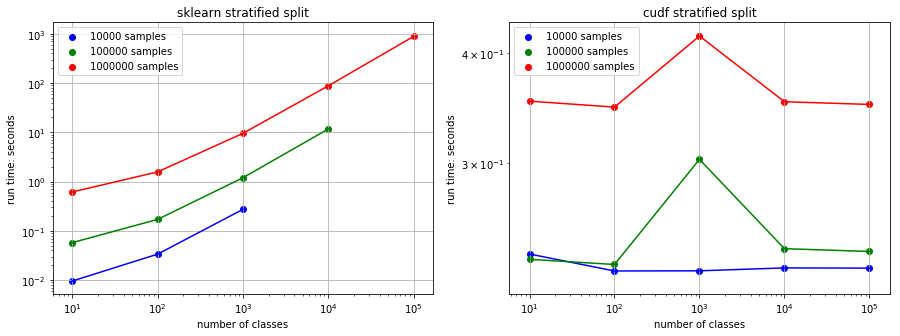

In [23]:
plt.figure(figsize=(15,5))
colors = ['b','g','r']

plt.subplot(1,2,1)
seq = {}
for samples,classes,t in sklearn_split_time:
    if samples not in seq:
        seq[samples] = [[],[]]
    seq[samples][0].append(classes)
    seq[samples][1].append(t)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('number of classes')
plt.ylabel('run time: seconds')
plt.grid()
for samples,color in zip(seq,colors):
    plt.scatter(seq[samples][0],seq[samples][1],c=color,label='%d samples'%samples)   
    plt.plot(seq[samples][0],seq[samples][1],c=color)
    plt.legend(loc='upper left')
    plt.title('sklearn stratified split')
    
plt.subplot(1,2,2)
seq = {}
for samples,classes,t in cudf_split_time:
    if samples not in seq:
        seq[samples] = [[],[]]
    seq[samples][0].append(classes)
    seq[samples][1].append(t)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('number of classes')
plt.ylabel('run time: seconds')
plt.grid()
for samples,color in zip(seq,colors):
    plt.scatter(seq[samples][0],seq[samples][1],c=color,label='%d samples'%samples)   
    plt.plot(seq[samples][0],seq[samples][1],c=color)
    plt.legend(loc='upper left')
    plt.title('cudf stratified split')

Based on the synthetic data results, I expect the sklearn's version get the landscape data done in more than an hour and cudf's version just takes 4 seconds hence the **1000x speedup**.